## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchattacks
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [3]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

## 3. Prepare Data

In [4]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [6]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [7]:
normal_data = image_folder_custom_label(root = './data/imagenet', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [8]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


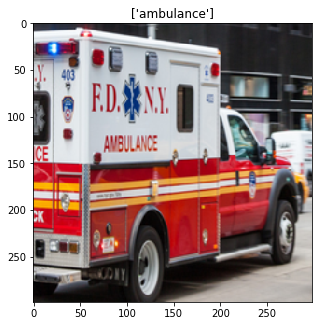

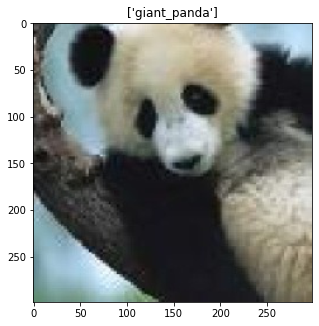

In [9]:
print("True Image & True Label")

for images, labels in normal_loader:   
    imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 4. Download the Inception v3

In [10]:
model = models.inception_v3(pretrained=True).to(device)

True Image & Predicted Label


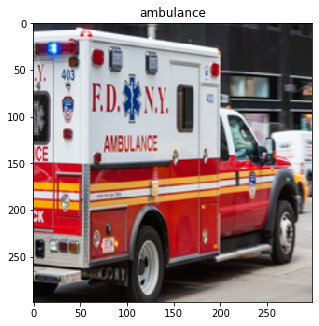

Top-1 (label, accuracy) is (ambulance, 95.172112)
Top-2 (label, accuracy) is (fire_engine, 0.590287)
Top-3 (label, accuracy) is (stretcher, 0.100391)
Top-4 (label, accuracy) is (tow_truck, 0.095773)
Top-5 (label, accuracy) is (police_van, 0.087405)


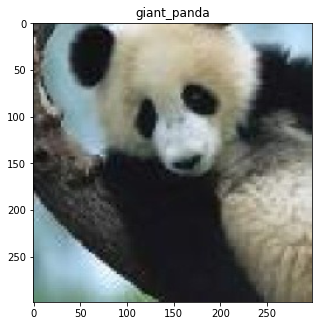

Top-1 (label, accuracy) is (giant_panda, 83.629631)
Top-2 (label, accuracy) is (indri, 3.200023)
Top-3 (label, accuracy) is (sea_slug, 0.277975)
Top-4 (label, accuracy) is (soccer_ball, 0.244130)
Top-5 (label, accuracy) is (kuvasz, 0.118690)


In [11]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
 
    topk=(1,5)
    maxk=max(topk)
    _, pred = torch.topk(outputs, maxk, dim=1, largest = True, sorted = True)
    percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), idx2label[pred.data[0][0]])

    # Print top-5 labels and their prediction accuracy as percentages
    for i in range(5):
        print('Top-%d (label, accuracy) is (%s, %f)' %((i+1), idx2label[pred.data[0][i]], percentage[pred.data[0][i]].item()) )
     


## 5. Adversarial Attack

$$\delta_{i} = \frac{1}{2}(tanh(w_{i})+1)-x_i$$   
$$minmize \Vert \frac{1}{2}(tanh(w)+1)-x\Vert^2_2 + c\cdot f(\frac{1}{2}(tanh(w)+1))$$   
$$f(x')=max(max\{ Z(x')_i:i\neq t \} - Z(x')_t, -\kappa) $$      

* Notation - $w$ : modifier, $t$ : class that $x'$ will be classified, $\kappa$ : confidence, $Z$ : classifier without last softmax

Attack Image & Predicted Label


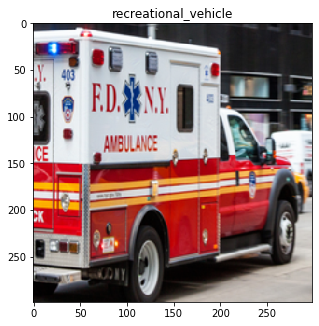

Top-1 (label, accuracy) is (recreational_vehicle, 27.719208)
Top-2 (label, accuracy) is (ambulance, 20.296986)
Top-3 (label, accuracy) is (fire_engine, 6.287251)
Top-4 (label, accuracy) is (mobile_home, 2.630525)
Top-5 (label, accuracy) is (tow_truck, 1.818643)


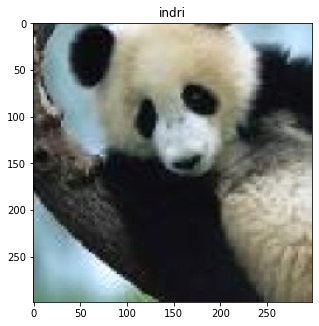

Top-1 (label, accuracy) is (indri, 84.352417)
Top-2 (label, accuracy) is (titi, 2.159334)
Top-3 (label, accuracy) is (giant_panda, 1.349922)
Top-4 (label, accuracy) is (capuchin, 0.907483)
Top-5 (label, accuracy) is (squirrel_monkey, 0.726022)


In [12]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
 
    CW_attack = torchattacks.CW(model, targeted=False, c=1, kappa=0, iters=1000, lr=0.01)
    adversarial_images = CW_attack(images, labels)
    labels = labels.to(device)
    outputs = model(adversarial_images)

    making_dir="./data/adversarial/%s" %(idx2label[labels])
    
    if not os.path.exists(making_dir):
        os.makedirs(making_dir)
        
    storing_file="./data/adversarial/%s/%s_on_CW.png" %(idx2label[labels], idx2label[labels])
    
    save_image(adversarial_images, storing_file)

    topk=(1,5)
    maxk=max(topk)
    _, pred = torch.topk(outputs, maxk, dim=1, largest = True, sorted = True)
    percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
    
    imshow(torchvision.utils.make_grid(adversarial_images.cpu().data, normalize=True), idx2label[pred.data[0][0]])

    # Print top-5 labels and their prediction accuracy as percentages
    for i in range(5):
        print('Top-%d (label, accuracy) is (%s, %f)' %((i+1), idx2label[pred.data[0][i]], percentage[pred.data[0][i]].item()) )
    

## 6. Mitigating adversarial perturbations CW attack generates 
 Mitigation is done by the script 'mitigating_adversarial_with_7x7_estimation.sh' in this site.  
 Then, the mitigation result is copied to the directory of './data/migitated/'.  
 Following shows how well the mitigation works on the CW perturbation.  


Mitigated Image & Predicted Label


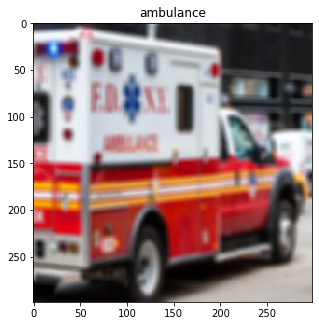

Top-1 (label, accuracy) is (ambulance, 92.987541)
Top-2 (label, accuracy) is (moving_van, 0.433774)
Top-3 (label, accuracy) is (recreational_vehicle, 0.323550)
Top-4 (label, accuracy) is (police_van, 0.282282)
Top-5 (label, accuracy) is (stretcher, 0.129362)


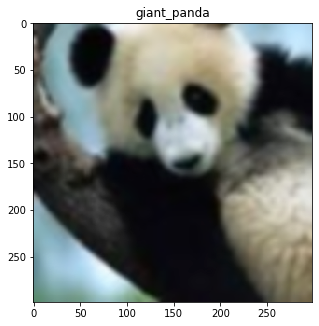

Top-1 (label, accuracy) is (giant_panda, 70.445892)
Top-2 (label, accuracy) is (indri, 9.419033)
Top-3 (label, accuracy) is (pick, 0.375384)
Top-4 (label, accuracy) is (colobus, 0.354920)
Top-5 (label, accuracy) is (sea_slug, 0.331669)


In [13]:
normal_data = image_folder_custom_label(root = './data/mitigated', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("Mitigated Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    topk=(1,5)
    maxk=max(topk)
    _, pred = torch.topk(outputs, maxk, dim=1, largest = True, sorted = True)
    percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), idx2label[pred.data[0][0]])

    # Print top-5 labels and their prediction accuracy as percentages
    for i in range(5):
        print('Top-%d (label, accuracy) is (%s, %f)' %((i+1), idx2label[pred.data[0][i]], percentage[pred.data[0][i]].item()) )
   